In [57]:
import json

import gizmo_analysis as gizmo  # rename these packages for brevity
import halo_analysis as halo
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import utilities as ut  # rename these packages for brevity
from astropy.io import ascii
from scipy.interpolate import make_smoothing_spline

In [176]:
simulation = "m12i"

simulation_directory = "/Users/z5114326/Desktop/fire/" + simulation + "/" + simulation + "_res7100"
sim_codes_path = "/Users/z5114326/Documents/GitHub/GC_kinematics_katana/data/external/simulation_codes.json"

with open(sim_codes_path) as json_file:
    sim_codes = json.load(json_file)

sim_tid = sim_codes[simulation]["halo"]
halt = halt = halo.io.IO.read_tree(simulation_directory)

hals_snaps = np.linspace(10, 600, 591, dtype=int)
hals = halo.io.IO.read_catalogs("index", hals_snaps, simulation_directory)

with open(simulation_directory + "/snapshot_times.txt") as f:
    content = f.readlines()
    content = content[5:]
snap_all = ascii.read(content)


# in utilities.simulation.Snapshot():
* reading:  Users/z5114326/Desktop/fire/m12i/m12i_res7100/snapshot_times.txt

* read 17859038 halos from:  Users/z5114326/Desktop/fire/m12i/m12i_res7100/halo/rockstar_dm/catalog_hdf5/tree.hdf5


# in utilities.simulation.Snapshot():
* reading:  Users/z5114326/Desktop/fire/m12i/m12i_res7100/snapshot_times.txt

* using snapshot indices = [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 16

In [73]:
sim_tid_idx = np.where(halt["tid"] == sim_tid)[0][0]
main_idx_lst = [sim_tid_idx]

for _ in range(1, 590):
    idx = halt["progenitor.main.index"][main_idx_lst[-1]]
    main_idx_lst.append(idx)

main_tid_lst = halt["tid"][main_idx_lst]
main_mass_lst = halt["mass"][main_idx_lst]
main_snap_lst = halt["snapshot"][main_idx_lst]
main_lbt_lst = [snap_all["lookback-time[Gyr]"][snap] for snap in main_snap_lst]

In [332]:
def plot_ready(lbt_lst, mass_lst, sim_codes, simulation):
    omega_b = sim_codes[simulation]["Ob"]
    omega_m = sim_codes[simulation]["Om"]
    f_b = omega_b / omega_m

    mass_cor_lst = [mass / (1 - f_b) for mass in mass_lst]

    lbt_sort = [x for _, x in sorted(zip(lbt_lst, lbt_lst))]
    mass_sort = [x for _, x in sorted(zip(lbt_sort, mass_cor_lst))]

    spl = make_smoothing_spline(lbt_sort, mass_sort)
    grid = np.linspace(lbt_sort[0], lbt_sort[-1], 1000)

    return grid, spl(grid)

In [9]:
halt.keys()

dict_keys(['am.phantom', 'am.progenitor.main', 'axis.b/a', 'axis.c/a', 'catalog.index', 'central.index', 'central.local.index', 'descendant.index', 'descendant.snapshot', 'dindex', 'final.index', 'host.distance', 'host.index', 'host.velocity', 'host.velocity.rad', 'host.velocity.tan', 'major.merger.snapshot', 'mass', 'mass.180m', 'mass.200c', 'mass.200m', 'mass.500c', 'mass.bound', 'mass.lowres', 'mass.vir', 'position', 'position.offset', 'progenitor.co.dindex', 'progenitor.co.index', 'progenitor.last.dindex', 'progenitor.main.index', 'progenitor.main.last.dindex', 'progenitor.number', 'radius', 'scale.radius', 'scale.radius.klypin', 'snapshot', 'spin.bullock', 'spin.peebles', 'tid', 'vel.circ.max', 'vel.std', 'velocity', 'velocity.offset'])

In [110]:
idx_interest_lst = np.where((halt["final.index"] == 0) & (halt["am.progenitor.main"] == 0))[0]

In [115]:
idx_interest_ref_lst = []

for idx in idx_interest_lst:
    idx_test = halt["descendant.index"][idx]

    if idx_test in main_idx_lst:
        idx_interest_ref_lst.append(idx)

In [121]:
np.where(halt["mass"][idx_interest_ref_lst] == np.max(halt["mass"][idx_interest_ref_lst]))[0][0]

12538

In [245]:
(
    halt["tid"][idx_interest_ref_lst[12538]],
    halt["snapshot"][idx_interest_ref_lst[12538]],
    halt["mass"][idx_interest_ref_lst[12538]],
    halt["catalog.index"][idx_interest_ref_lst[12538]],
)

(1920378, 126, 35893160000.0, 16082)

START AGAIN

In [247]:
idx_interest_lst = np.where((halt["final.index"] == 0) & (halt["am.progenitor.main"] == 0))[0]

In [249]:
catalog_idx_lst = halt["catalog.index"][idx_interest_lst]
snapshot_interest_lst = halt["snapshot"][idx_interest_lst]

In [293]:
first_infall_lst = []
first_infall_snap_lst = []
test_lst = []

for snapshot, cat_idx in zip(snapshot_interest_lst, catalog_idx_lst):
    if snapshot >= 10:
        hal = hals[snapshot]
        first_infall_lst.append(hal["infall.first.mass"][cat_idx])
        test_lst.append(snapshot)
        first_infall_snap_lst.append(hal["infall.first.snapshot"][cat_idx])

first_infall_lst_dup = list(dict.fromkeys(first_infall_lst))
first_infall_lst_dup.sort(reverse=True)

In [347]:
large = 0

idx_test = np.where(first_infall_lst == first_infall_lst_dup[large])[0][0]
snap_interest = first_infall_snap_lst[idx_test]
snap_interest
# test_lst[idx_test]

211

In [344]:
idx_wow = np.where(hals[snap_interest]["infall.first.mass"] == first_infall_lst_dup[large])[0][0]
tree_idx_wow = hals[snap_interest]["tree.index"][idx_wow]

mass_base = halt["mass"][tree_idx_wow]
snap_base = halt["snapshot"][tree_idx_wow]

prog_idx_lst = [tree_idx_wow]

for _ in range(10, snap_base):
    idx = halt["progenitor.main.index"][prog_idx_lst[-1]]
    prog_idx_lst.append(idx)

prog_mass_lst = halt["mass"][prog_idx_lst]
prog_snap_lst = halt["snapshot"][prog_idx_lst]
prog_lbt_lst = [snap_all["lookback-time[Gyr]"][snap] for snap in prog_snap_lst]

In [345]:
omega_b = sim_codes[simulation]["Ob"]
omega_m = sim_codes[simulation]["Om"]
f_b = omega_b / omega_m

mass_test = halt["mass"][tree_idx_wow] / (1 - f_b)
lbt_test = snap_all["lookback-time[Gyr]"][halt["snapshot"][tree_idx_wow]]

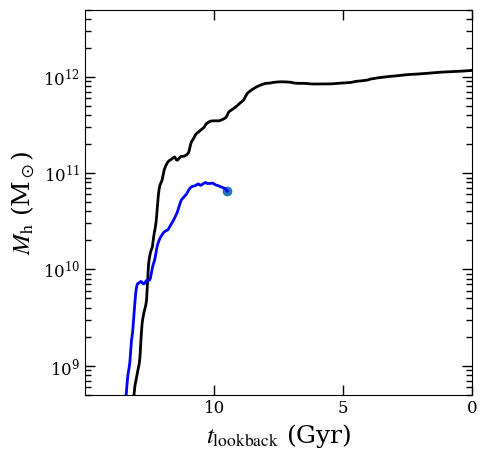

In [346]:
params = {"font.family": "serif", "mathtext.fontset": "stix", "font.size": 12}
matplotlib.rcParams.update(params)

fig, ax = plt.subplots(figsize=(5, 5))

main_lbt, main_mass = plot_ready(main_lbt_lst, main_mass_lst, sim_codes, simulation)
ax.plot(main_lbt, main_mass, c="k", lw=2)

plt.scatter(lbt_test, mass_test)

prog_lbt, prog_mass = plot_ready(prog_lbt_lst, prog_mass_lst, sim_codes, simulation)
ax.plot(prog_lbt, prog_mass, c="blue", lw=2)

ax.set_xlabel(r"$t_{\rm lookback}$ (Gyr)", fontsize=18)
ax.set_ylabel(r"$M_{\rm h}$ (M$_\odot$)", fontsize=18)

ax.set_yscale("log")
ax.set_xticks([0, 5, 10])
ax.set_xlim([15, 0])
ax.set_ylim([5 * 10**8, 5 * 10**12])
ax.tick_params(which="both", direction="in", right=True, top=True, width=1)
ax.tick_params(which="major", length=7)
ax.tick_params(which="minor", length=4)